In [24]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
%load_ext autoreload
%autoreload 2

In [343]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,\
TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,\
Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))

56 57 72


In [395]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*0.5
drivingcost_per_mile=0.75
transit_fare=1
reward_mode=2
run_mode=0

cav_use_mode=1
num_time_interval=1

In [229]:
traveler_trips.sort_values(by=['hh_id','person_id'],inplace=True)

In [353]:
print(datetime.datetime.now())
zz=prd.compare_mode_utlity(traveler_trips.loc
                         [(traveler_trips.tripmode !=7) & (traveler_trips.tripmode !=8)],1
                        ,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,
                           TransitSkimTimeIntervalLength,WalkSpeed,Vehicular_Skim_Dict,
                           superzone_map,drivingcost_per_mile,transit_zone_dict)
print(datetime.datetime.now())

2018-07-13 13:05:52.424701


D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # sorted_trips[['transit_utility','transit_time','transit_walk_time']]
D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  transit_zone_dict,0)],axis=1)
D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

TypeError: ("'>' not supported between instances of 'list' and 'float'", 'occurred at index 0')

In [242]:
len(traveler_trips)

382158

In [ ]:
zz['transit_utility']=zz.apply(lambda row: 
        prd.estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,row.value_of_time,
                        TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,WalkSpeed,
                        transit_zone_dict,0),axis=1)

In [403]:
zz['car_utility']=zz.apply(lambda row: 
        (prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile)), axis=1)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [419]:
zz['predicted_mode']=zz.apply(lambda row:
        'NonCar' if row.transit_utility<row.car_utility else 'Car',axis=1)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [354]:
zz.groupby(['tripmode']).count()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,orig_purpose,dest_purpose,orig_maz,orig_taz,dest_maz,...,early_penalty_threshold,late_penalty_threshold,transit_time,transit_walk_time,transit_utility,car_time,car_dist,toll_cost,car_utility,actual_mode
tripmode,,,,,,,,,,,,,,,,,,,,,
1,173121,173121,173121,173121,173121,173121,173121,173121,173121,173121,...,173121,173121,173121,173121,173121,173121,173121,173121,173121,173121
3,75304,75304,75304,75304,75304,75304,75304,75304,75304,75304,...,75304,75304,75304,75304,75304,75304,75304,75304,75304,75304
5,52429,52429,52429,52429,52429,52429,52429,52429,52429,52429,...,52429,52429,52429,52429,52429,52429,52429,52429,52429,52429
10,4039,4039,4039,4039,4039,4039,4039,4039,4039,4039,...,4039,4039,4039,4039,4039,4039,4039,4039,4039,4039
11,314,314,314,314,314,314,314,314,314,314,...,314,314,314,314,314,314,314,314,314,314
12,404,404,404,404,404,404,404,404,404,404,...,404,404,404,404,404,404,404,404,404,404
13,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,...,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037
14,5384,5384,5384,5384,5384,5384,5384,5384,5384,5384,...,5384,5384,5384,5384,5384,5384,5384,5384,5384,5384


In [417]:
zz[zz.tripmode<12].groupby(['predicted_mode','actual_mode']).count()

person_id  num_trips  value_of_time  trip_counter  \
predicted_mode actual_mode                                                      
Car            Car             266098     266098         266098        266098   
               NonCar            3682       3682           3682          3682   
NonCar         Car              34756      34756          34756         34756   
               NonCar             671        671            671           671   

                            ActivityTime  tripmode  orig_purpose  \
predicted_mode actual_mode                                         
Car            Car                266098    266098        266098   
               NonCar               3682      3682          3682   
NonCar         Car                 34756     34756         34756   
               NonCar                671       671           671   

                            dest_purpose  orig_maz  orig_taz     ...       \
predicted_mode actual_mode                                       ...        
Car            Car                266098    266098    266098     ...        
               NonCar               3682      3682      3682     ...        
NonCar         Car                 34756     34756     34756     ...        
               NonCar                671       671       671     ...        

                            latearr_penalty  early_penalty_threshold  \
predicted_mode actual_mode                                             
Car            Car                   266098                   266098   
               NonCar                  3682                     3682   
NonCar         Car                    34756                    34756   
               NonCar                   671                      671   

                            late_penalty_threshold  transit_time  \
predicted_mode actual_mode                                         
Car            Car                          266098        266098   
               NonCar                         3682          3682   
NonCar         Car                           34756         34756   
               NonCar                          671           671   

                            transit_walk_time  transit_utility  car_time  \
predicted_mode actual_mode                                                 
Car            Car                     266098           266098    266098   
               NonCar                    3682             3682      3682   
NonCar         Car                      34756            34756     34756   
               NonCar                     671              671       671   

                            car_dist  toll_cost  car_utility  
predicted_mode actual_mode                                    
Car            Car            266098     266098       266098  
               NonCar           3682       3682         3682  
NonCar         Car             34756      34756        34756  
               NonCar            671        671          671  

[4 rows x 34 columns]

In [420]:
zz[zz.tripmode<12].groupby(['predicted_mode']).count()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,early_penalty_threshold,late_penalty_threshold,transit_time,transit_walk_time,transit_utility,car_time,car_dist,toll_cost,car_utility,actual_mode
predicted_mode,,,,,,,,,,,,,,,,,,,,,
Car,283806,283806,283806,283806,283806,283806,283806,283806,283806,283806,...,283806,283806,283806,283806,283806,283806,283806,283806,283806,283806
NonCar,21401,21401,21401,21401,21401,21401,21401,21401,21401,21401,...,21401,21401,21401,21401,21401,21401,21401,21401,21401,21401


In [400]:
zz[zz.tripmode<12].groupby(['actual_mode']).count()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,early_penalty_threshold,late_penalty_threshold,transit_time,transit_walk_time,transit_utility,car_time,car_dist,toll_cost,car_utility,predicted_mode
actual_mode,,,,,,,,,,,,,,,,,,,,,
Car,300854,300854,300854,300854,300854,300854,300854,300854,300854,300854,...,300854,300854,300854,300854,300854,300854,300854,300854,300854,300854
NonCar,4353,4353,4353,4353,4353,4353,4353,4353,4353,4353,...,4353,4353,4353,4353,4353,4353,4353,4353,4353,4353


In [333]:
three_link_walk[(three_link_walk.three_link_zone==1)&(three_link_walk.transit_zone==4)]

,three_link_zone,transit_zone,distance
0,1.0,4.0,4702.091222


In [322]:
three_link_walk.head()

,three_link_zone,transit_zone,distance
0,1.0,4.0,4702.091222
1,1.0,24.0,18806.588630
2,1.0,37.0,18982.033670
3,1.0,65.0,21330.843820
4,1.0,39.0,21422.376550


In [334]:
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance

1.0 4.0 4702.091222
1.0 24.0 18806.58863
1.0 37.0 18982.03367
1.0 65.0 21330.84382
1.0 39.0 21422.37655
1.0 34.0 22126.08161
2.0 4.0 2685.936967
2.0 24.0 16669.74572
2.0 65.0 19194.00091
2.0 34.0 19989.23871
2.0 37.0 20376.01122
2.0 45.0 21000.53835
3.0 4.0 3960.582399
3.0 24.0 16684.43064
3.0 37.0 16727.70532
3.0 39.0 19168.0482
3.0 65.0 19208.68583
3.0 34.0 20003.92362
4.0 4.0 0.0
4.0 24.0 14104.50243
4.0 65.0 16628.75762
4.0 34.0 17423.99541
4.0 37.0 17690.07927
4.0 45.0 18314.6064
5.0 4.0 5766.338899
5.0 24.0 14054.67646
5.0 65.0 16578.93165
5.0 34.0 17374.16945
5.0 45.0 19015.02367
5.0 66.0 19735.72313
6.0 4.0 8315.86937
6.0 24.0 12831.94102
6.0 65.0 15356.19621
6.0 34.0 16151.434
6.0 66.0 18512.98768
6.0 36.0 18687.12568
7.0 4.0 3009.649179
7.0 24.0 11821.59002
7.0 65.0 14345.84521
7.0 34.0 15141.083
7.0 45.0 16781.93723
7.0 66.0 17502.63668
8.0 4.0 5758.812477
8.0 24.0 10040.20796
8.0 65.0 12564.46315
8.0 34.0 13359.70095
8.0 66.0 15721.25463
8.0 36.0 15895.39262
9.0 4.0 10823.4

In [342]:
transit_skim_dict=prd.extract_transit_utility_skim(TransitMazTazFlag,traveler_trips,three_link_walk_dict,
    Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,WalkSpeed,transit_zone_dict)

In [346]:
Transit_AB_Cost_Skim.head()

,otap,dtap,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,24.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
2,4.0,34.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
3,4.0,36.0,1440.0,1440.0,1440.0,1440.0,109.7,82.4,83.4,110.7,...,1440.0,1440.0,1440.0,1440.0,1440.0,111.7,1440.0,1440.0,1440.0,1440.0
4,4.0,37.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,...,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0


In [349]:
three_link_walk_dict[4]

{4.0: 0.0,
 24.0: 14104.50243,
 34.0: 17423.99541,
 37.0: 17690.079269999998,
 45.0: 18314.606400000001,
 65.0: 16628.75762}

In [347]:
transit_skim_dict[4][36][4]

{'transit_time': 46.399999999999999,
 'utility': 15.38675232447158,
 'walk_time': 0.0}

In [261]:
traveler_trips[(traveler_trips.tripmode<=6 )&(traveler_trips.driver_passenger_flag>0)].value_of_time.mean()

0.17107082153243827

In [265]:
traveler_trips[(traveler_trips.tripmode>=9) &(traveler_trips.tripmode<=12)].value_of_time.median()

0.1807

In [42]:
z=[]
for i in range(1,56):
    for j in range(1,56):
        z.extend([Vehicular_Skim1.loc[i,j,:,1].Time.max()-Vehicular_Skim1.loc[i,j,:,1].Time.min()])

In [ ]:
z1=[]
for i in range(1,56):
    for j in range(1,56):
        z1.extend([Vehicular_Skim.loc[i,j,:,1].Time.max()-Vehicular_Skim.loc[i,j,:,1].Time.min()])

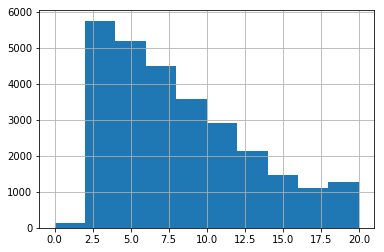

In [30]:
traveler_trips[traveler_trips.tripmode<=6].groupby(['hh_id']).count().person_id.hist(range=(0,20))